In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt

$\varphi_{k,j} = \frac{d}{\lambda}\operatorname{cos}(\varphi_{\theta}) \in [-0.5, 0.5)$

$$
\mathbf{a}_{X}(x)=\left[1, e^{-\mathrm{i} 2 \pi x}, \ldots, e^{-\mathrm{i} 2 \pi(X-1) x}\right]^{\mathrm{T}}
$$

$\Delta \varphi_{k,j}=\varphi_{k,j} -\varphi_{k,j}^g \in [0,\frac{1}{M})$

$${\boldsymbol p}_{l,k} = {\mathbf \Phi}^H {\mathbf V}({\omega_l}){\mathbf D}_M({\Delta}{\boldsymbol \varphi}_k) {\boldsymbol x}_k
+ {\mathbf N}_l ,\forall l \in \{1,\dots,L\}$$

${\boldsymbol x}_k \in {\mathbb R}^{M\times 1}$  ${\boldsymbol x}_{k,m} \in \{ 0,1\}$


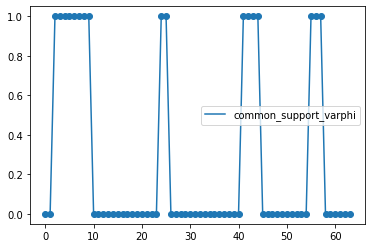

In [30]:
## generate channel support
K=4
np.random.seed(6)
def common_channel_support(p01 = 0.1, p10=0.3, M= 64):
    p0 = p10/(p10+p01)
    p1 = 1-p0

    # generate Markov chain
    tmp_support = np.array([0.0 for m in range(M)])
    if np.random.uniform(0,1,1)[0] < p0:
        tmp_support[0] = 0
    for i in range(M - 1):
        if tmp_support[i] == 0:
            if np.random.uniform(0,1,2)[0] < p01:
                tmp_support[i+1] = 1
            else:
                tmp_support[i+1] = 0
        else:
            if np.random.uniform(0,1,2)[1] < p10:
                tmp_support[i+1] = 0
            else:
                tmp_support[i+1] = 1
    return tmp_support
p01 = 0.1 
p10 = 0.3
M = 64
common_support_varphi = common_channel_support(p01, p10, M)
plt.scatter(range(M), common_support_varphi)
plt.plot(range(M), common_support_varphi)
plt.legend(['common_support_varphi'])


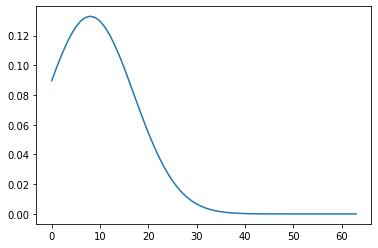

In [34]:
# generate individual AoAs
def pdf_for_all_user(user_index, K = 4, M = 64, sigma = 6):
    x = np.linspace(0,M-1,M)
    mu = int(user_index*(M/K)+0.5*M/K)
    return 1/(np.power(2*np.pi*np.power(sigma,2), 0.5)) * np.exp(-0.5 * np.power((x-mu)/np.power(sigma,2),2))

plt.plot(range(M), pdf_for_all_user(0,K,M,sigma=3))

${\mathbf D}_M(\Delta {\boldsymbol \varphi})= [D_M(\Delta \varphi_1),\dots,D_M(\Delta \varphi_M)] \in {\mathbb C}^{M\times M}$

$$
D_M(\Delta {\varphi_1})_{m^{\prime}}=\begin{cases}
\begin{aligned}
f_M({2\pi}(\frac{m^{\prime}-m} {M}+\Delta\varphi))\ &, \frac{m^{\prime}-1}{M} < 0.5 \\
f_M({2\pi}(\frac{m^{\prime}-m+M} {M}+\Delta\varphi)) &, \frac{m^{\prime}-1}{M} \geq 0.5
\end{aligned}

\end{cases}
$$

In [ ]:
## generate D_M
